## COVID-19 Data Analysis

Jay Urbain, PhD

References:  

Interview
Ari Libsker, Corona Is Slowing Down, Humanity Will Survive, Says Biophysicist Michael Levitt, 3/13/20.  
https://www.calcalistech.com/ctech/articles/0,7340,L-3800632,00.html

2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
https://github.com/CSSEGISandData/COVID-19

The COVID Tracking Project from *The Atlantic*  
https://covidtracking.com/

## Recommended conda environment setup
conda create -n main python=3.8

conda activate main

conda install numpy pandas matplotlib plotly IPython ipywidgets seaborn

pip install yfinance pykalman

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

In [2]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [15, 5]
from IPython import display
from ipywidgets import interact, widgets
import seaborn as sns

#### Data

The data is hosted by John Hopkins University:  
https://github.com/CSSEGISandData/COVID-19

There are three files that contain total confirmed cases, deaths and recoveries.

In [3]:
## Read Data for Cases, Deaths and Recoveries
csse_prefix = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed_raw = pd.read_csv(csse_prefix + 'time_series_covid19_confirmed_global.csv')
df_deaths_raw    = pd.read_csv(csse_prefix + 'time_series_covid19_deaths_global.csv')
df_recovered_raw = pd.read_csv(csse_prefix + 'time_series_covid19_recovered_global.csv')

In [4]:
df_confirmed_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35


#### Data Preprocessing

Unpivot the data

In [5]:
# melt df into correct shape 
# index
def unpivot_data(df_raw):
    df_unpivot=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'], value_name='Cases', var_name='Date')
    df_unpivot['Date'] = pd.to_datetime(df_unpivot['Date'])
    df_unpivot=df_unpivot.set_index(['Date'])
    return df_unpivot 

# Unpivot datasets datasets
df_confirmed=unpivot_data(df_confirmed_raw)
df_deaths=unpivot_data(df_deaths_raw)
df_recovered=unpivot_data(df_recovered_raw)


In [6]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0


In [7]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0


In [8]:
df_recovered.head()

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0


List countries

In [9]:
np.sort(df_confirmed['Country/Region'].unique())

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [10]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0


In [11]:
df_confirmed[df_confirmed['Country/Region'] == 'France']

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,French Guiana,France,3.9339,-53.1258,0
2020-01-22,French Polynesia,France,-17.6797,149.4068,0
2020-01-22,Guadeloupe,France,16.2500,-61.5833,0
2020-01-22,Mayotte,France,-12.8275,45.1662,0
2020-01-22,New Caledonia,France,-20.9043,165.6180,0
...,...,...,...,...,...
2020-05-02,Saint Barthelemy,France,17.9000,-62.8333,6
2020-05-02,St Martin,France,18.0708,-63.0501,38
2020-05-02,Martinique,France,14.6415,-61.0242,179


In [12]:
df_confirmed[df_confirmed['Country/Region'] == 'United Kingdom']

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,Bermuda,United Kingdom,32.3078,-64.7505,0
2020-01-22,Cayman Islands,United Kingdom,19.3133,-81.2546,0
2020-01-22,Channel Islands,United Kingdom,49.3723,-2.3644,0
2020-01-22,Gibraltar,United Kingdom,36.1408,-5.3536,0
2020-01-22,Isle of Man,United Kingdom,54.2361,-4.5481,0
...,...,...,...,...,...
2020-05-02,NaN,United Kingdom,55.3781,-3.4360,182260
2020-05-02,Anguilla,United Kingdom,18.2206,-63.0686,3
2020-05-02,British Virgin Islands,United Kingdom,18.4207,-64.6400,6


In [13]:
df_confirmed_us = df_confirmed[df_confirmed['Country/Region'] == 'US']
df_confirmed_us

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,US,37.0902,-95.7129,1
2020-01-23,NaN,US,37.0902,-95.7129,1
2020-01-24,NaN,US,37.0902,-95.7129,2
2020-01-25,NaN,US,37.0902,-95.7129,2
2020-01-26,NaN,US,37.0902,-95.7129,5
...,...,...,...,...,...
2020-04-28,NaN,US,37.0902,-95.7129,1012582
2020-04-29,NaN,US,37.0902,-95.7129,1039909
2020-04-30,NaN,US,37.0902,-95.7129,1069424


In [17]:
df_confirmed_us_total = pd.DataFrame(df_confirmed_us.groupby(df_confirmed_us.index)['Cases'].sum(), columns=['Cases'])
df_confirmed_us_total['Country/Region'] = 'US Total'
df_confirmed_us_total

,Cases,Country/Region
Date,,
2020-01-22,1,US Total
2020-01-23,1,US Total
2020-01-24,2,US Total
2020-01-25,2,US Total
2020-01-26,5,US Total
...,...,...
2020-04-28,1012582,US Total
2020-04-29,1039909,US Total
2020-04-30,1069424,US Total


In [18]:
df_confirmed = df_confirmed.append(df_confirmed_us_total)
df_confirmed

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0
...,...,...,...,...,...
2020-04-28,NaN,US Total,NaN,NaN,1012582
2020-04-29,NaN,US Total,NaN,NaN,1039909
2020-04-30,NaN,US Total,NaN,NaN,1069424


#### China Total

In [19]:
df_confirmed_china = df_confirmed[df_confirmed['Country/Region'] == 'China']
df_confirmed_china

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,Anhui,China,31.8257,117.2264,1
2020-01-22,Beijing,China,40.1824,116.4142,14
2020-01-22,Chongqing,China,30.0572,107.8740,6
2020-01-22,Fujian,China,26.0789,117.9874,1
2020-01-22,Gansu,China,37.8099,101.0583,0
...,...,...,...,...,...
2020-05-02,Tianjin,China,39.3054,117.3230,190
2020-05-02,Tibet,China,31.6927,88.0924,1
2020-05-02,Xinjiang,China,41.1129,85.2401,76


In [20]:
df_confirmed_china_total = pd.DataFrame(df_confirmed_china.groupby(df_confirmed_china.index)['Cases'].sum(), columns=['Cases'])
df_confirmed_china_total['Country/Region'] = 'China Total'
df_confirmed_china_total

,Cases,Country/Region
Date,,
2020-01-22,548,China Total
2020-01-23,643,China Total
2020-01-24,920,China Total
2020-01-25,1406,China Total
2020-01-26,2075,China Total
...,...,...
2020-04-28,83940,China Total
2020-04-29,83944,China Total
2020-04-30,83956,China Total


In [21]:
df_confirmed = df_confirmed.append(df_confirmed_china_total)
df_confirmed

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0
...,...,...,...,...,...
2020-04-28,NaN,China Total,NaN,NaN,83940
2020-04-29,NaN,China Total,NaN,NaN,83944
2020-04-30,NaN,China Total,NaN,NaN,83956


Cap date range to today to eliminate spurious data

In [22]:
from datetime import date
max_date = date.today()
max_date

datetime.date(2020, 5, 3)

In [23]:
df_confirmed.index.values.max(), df_confirmed.index.values.min()

(numpy.datetime64('2020-05-02T00:00:00.000000000'),
 numpy.datetime64('2020-01-22T00:00:00.000000000'))

In [24]:
df_confirmed[df_confirmed['Country/Region']=='US'].index.values.max(), df_confirmed.index.values.min()

(numpy.datetime64('2020-05-02T00:00:00.000000000'),
 numpy.datetime64('2020-01-22T00:00:00.000000000'))

In [25]:
min_date_string = np.datetime_as_string(df_confirmed.index.values.min(), unit='D')
max_date_string = np.datetime_as_string(df_confirmed.index.values.max(), unit='D')

In [26]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,0
2020-01-22,NaN,Albania,41.1533,20.1683,0
2020-01-22,NaN,Algeria,28.0339,1.6596,0
2020-01-22,NaN,Andorra,42.5063,1.5218,0
2020-01-22,NaN,Angola,-11.2027,17.8739,0


#### US Polyfit,  Median Filter,  % Change, Testing

US Testing data

In [57]:
df_state_raw = pd.read_csv('https://covidtracking.com/api/v1/us/daily.csv', parse_dates=['date',])
# Old local source had fields: date, states, positive, posNeg (sum), pending, death, total (=posNeg+pending)
df_us_testing=df_state_raw.set_index(['date'])
df_us_testing

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-05-02,56,1125719,5690628.0,1578.0,51554.0,123860.0,9403.0,4386.0,4845.0,375.0,...,123860.0,6817925,6816347,6816347,NaN,1651.0,2112.0,234499.0,30038.0,264537.0
2020-05-01,56,1095681,5456129.0,1639.0,52370.0,121748.0,9205.0,4300.0,4707.0,376.0,...,121748.0,6553449,6551810,6551810,NaN,1743.0,9793.0,271571.0,33547.0,305118.0
2020-04-30,56,1062134,5184558.0,2775.0,53793.0,111955.0,9486.0,4192.0,4712.0,373.0,...,111955.0,6249467,6246692,6246692,NaN,2091.0,2265.0,191545.0,28977.0,220522.0
2020-04-29,56,1033157,4993013.0,4832.0,54930.0,109690.0,9612.0,4093.0,4796.0,365.0,...,109690.0,6031002,6026170,6026170,NaN,2700.0,3382.0,202877.0,27565.0,230442.0
2020-04-28,56,1005592,4790136.0,4206.0,54940.0,106308.0,9491.0,3798.0,4760.0,195.0,...,106308.0,5799934,5795728,5795728,NaN,2198.0,2059.0,177775.0,24458.0,202233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0
2020-01-25,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0
2020-01-24,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0


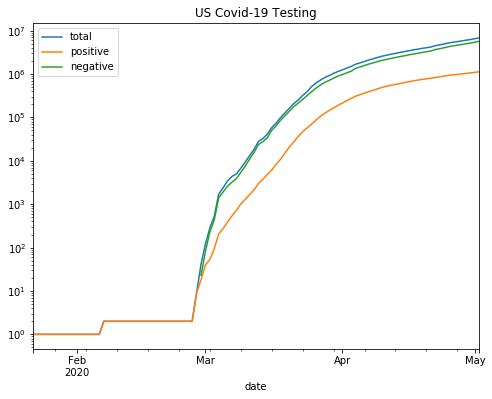

In [58]:
df_us_testing[['total','positive','negative']].plot(figsize=(8,6), title='US Covid-19 Testing', logy=True)

#### US Confirmed Cases

Total and percent change

In [27]:
min_cases = 50

In [45]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'US Total') & (df_confirmed['Cases'] >= min_cases)]
df = df_country['Cases'].pct_change().to_frame('Percent Change').reset_index()[1:]
df
x = df.index
xDate = df_country.index[1:]
y = df['Percent Change']
# print(x, y)
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
p

poly1d([-2.52038377e-07,  4.78406607e-05, -3.04672384e-03,  6.72863498e-02,
       -1.07599345e-01])

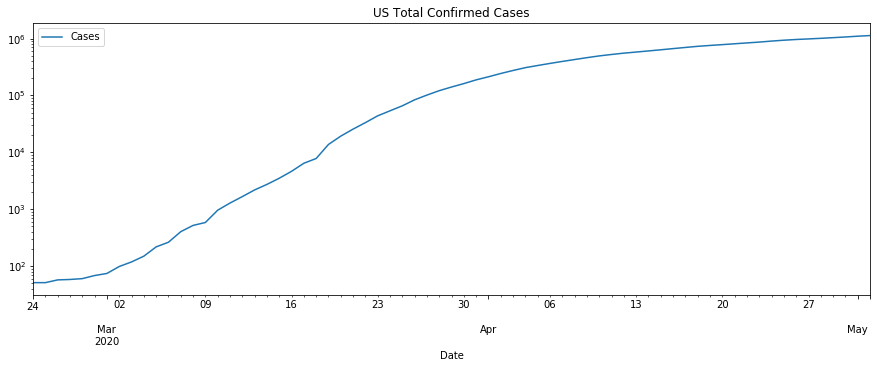

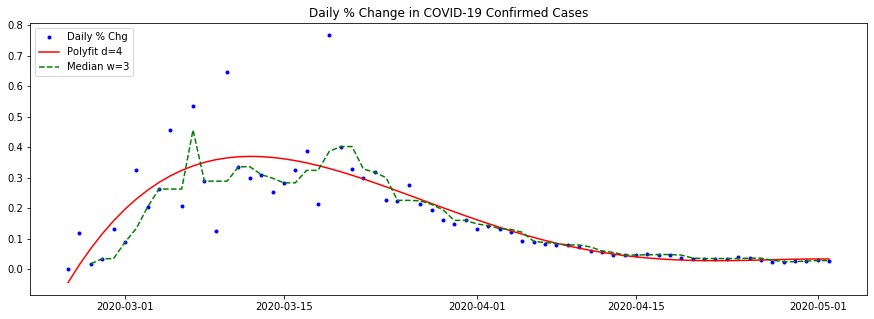

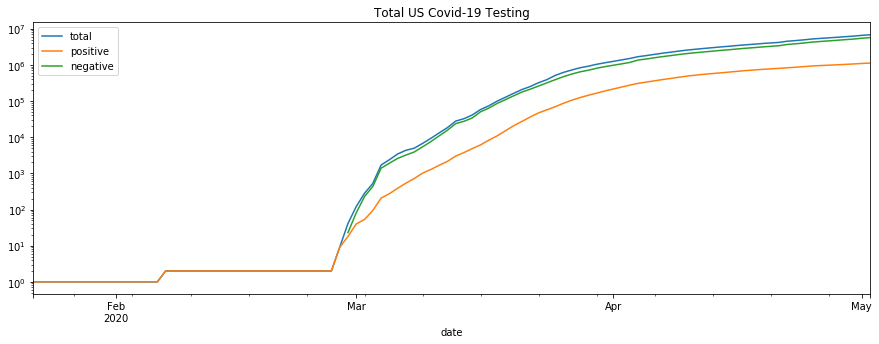

In [46]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'US Total') & (df_confirmed['Cases'] >= min_cases)]
df_country.plot(y='Cases', title='US Total Confirmed Cases', logy=True)

ma = y.rolling(window=3).median()
fig, ax = plt.subplots()
ax.set_title('Daily % Change in COVID-19 Confirmed Cases')
ax.plot(xDate, y, '.b', label='Daily % Chg')
ax.plot(xDate, p(x), '-r', label='Polyfit d=4')
ax.plot(xDate, ma, '--g', label='Median w=3')
leg = ax.legend(loc='upper left', frameon=True);
plt.show()

df_us_testing[['total','positive','negative']].plot(title='Total US Covid-19 Testing', logy=True)

#### China Confirmed Cases,  Polyfit and Median Filter % Change

In [59]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'China Total') & (df_confirmed['Cases'] >= min_cases)]
df = df_country['Cases'].pct_change().to_frame('Percent Change').reset_index()[1:]
df
x = df.index
xDate = df_country.index[1:]
y = df['Percent Change']
# print(x, y)
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
p

poly1d([ 2.56707460e-08, -7.39704943e-06,  7.68217086e-04, -3.37889448e-02,
        5.26245190e-01])

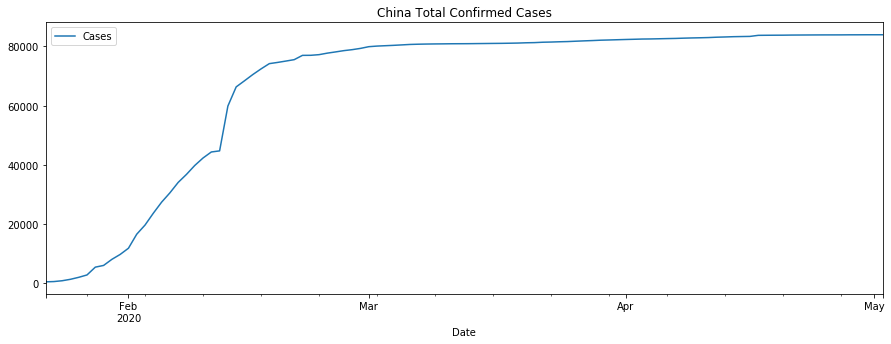

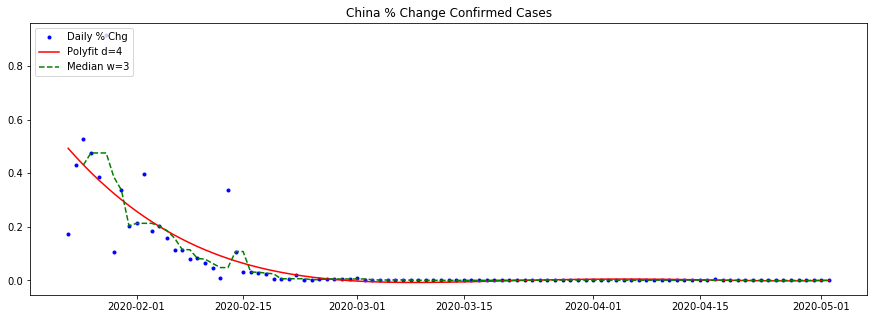

In [60]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'China Total') & (df_confirmed['Cases'] >= min_cases)]
df_country.plot(y='Cases', title='China Total Confirmed Cases')

ma = y.rolling(window=3).median()
fig, ax = plt.subplots()
ax.plot(xDate, y, '.b', label='Daily % Chg')
ax.plot(xDate, p(x), '-r', label='Polyfit d=4')
ax.plot(xDate, ma, '--g', label='Median w=3')
plt.title('China % Change Confirmed Cases')
leg = ax.legend(loc='upper left', frameon=True);

#### South Korea Confirmed Cases, Polyfit and Median Filter % Change

In [64]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Korea, South') & (df_confirmed['Cases'] >= min_cases)]

Load South Korea test data

In [66]:
# Not sure what the original South Korea data source was, perhaps this:
# https://ourworldindata.org/grapher/full-list-total-tests-for-covid-19
# They seem to block scripted downloads, using a local static copy

#kdn_fn = '/Users/jayurbain/Dropbox/covid19_jay/covid19/data/Korea_Daily_Numbers_Jay.csv'
#keyKoreaTotalTests = 'Total Tests'

kdn_fn = r'C:\Users\durant\Downloads\full-list-total-tests-for-covid-19.csv'
keyKoreaTotalTests = 'Total tests' # case is different than other data set

df_south_korea_testing_raw = pd.read_csv(kdn_fn)

df_south_korea_testing=df_south_korea_testing_raw.set_index(['Date'])
df_south_korea_testing = pd.DataFrame(df_south_korea_testing[keyKoreaTotalTests], columns=[keyKoreaTotalTests]).loc[
    (df_south_korea_testing['Code'] == 'KOR')] # or ['Entity'] == 'South Korea'
df_south_korea_testing

,Total tests
Date,
"Jan 21, 2020",11
"Jan 22, 2020",16
"Jan 24, 2020",25
"Jan 26, 2020",48
"Jan 27, 2020",57
...,...
"Apr 27, 2020",601660
"Apr 28, 2020",608514
"Apr 29, 2020",614197


In [67]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Korea, South') & (df_confirmed['Cases'] >= min_cases)]

df = df_country['Cases'].to_frame('Cases').reset_index()[1:]
df
x = df.index
xDates = df_country.index[1:]
y = df['Cases']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
p

poly1d([-1.22349046e-03,  2.49685999e-01, -1.97527861e+01,  7.56696998e+02,
       -1.67333862e+03])

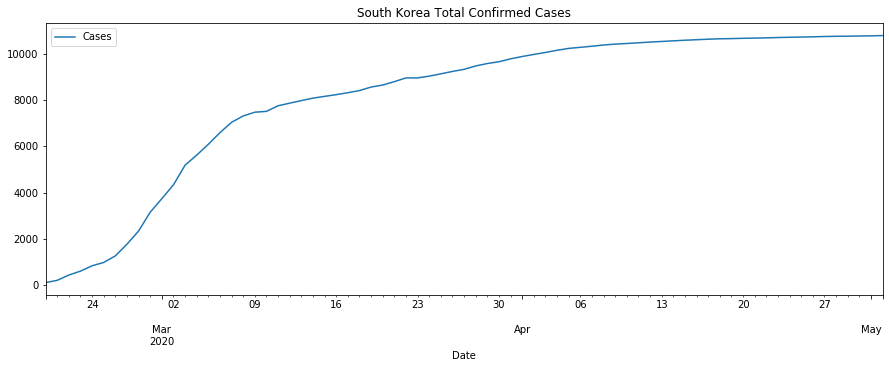

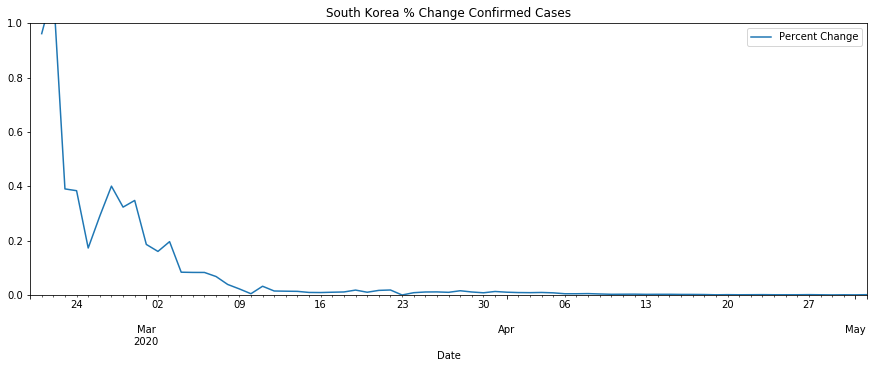

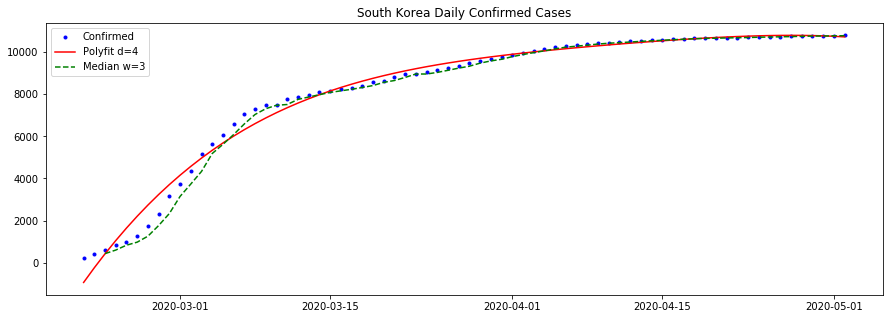

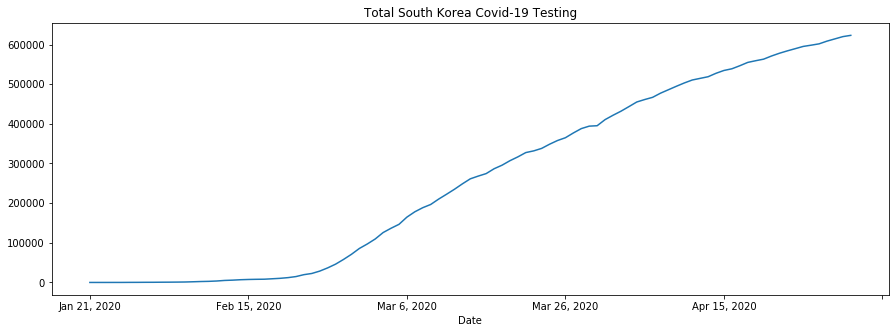

In [68]:
df_country.plot(y='Cases', title='South Korea Total Confirmed Cases')

# plt.show()

df_country['Cases'].pct_change().to_frame('Percent Change').plot(title='South Korea % Change Confirmed Cases', ylim=(0,1.0))

ma = y.rolling(window=3).median()
fig, ax = plt.subplots()
plt.title('South Korea Daily Confirmed Cases')
ax.plot(xDates, y, '.b', label='Confirmed')
ax.plot(xDates, p(x), '-r', label='Polyfit d=4')
ax.plot(xDates, ma, '--g', label='Median w=3')
leg = ax.legend(loc='upper left', frameon=True)
plt.show()

df_south_korea_testing[keyKoreaTotalTests].plot(title='Total South Korea Covid-19 Testing');

In [71]:
df = df_country['Cases'].pct_change().to_frame('Percent Change').reset_index()[1:]
df
x = df.index
xDate = df_country.index[1:]
y = df['Percent Change']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
p

poly1d([ 3.89056331e-07, -6.77799929e-05,  4.14385426e-03, -1.04087869e-01,
        9.04930947e-01])

,Total tests
Date,
"Jan 21, 2020",11
"Jan 22, 2020",16
"Jan 24, 2020",25
"Jan 26, 2020",48
"Jan 27, 2020",57
...,...
"Apr 27, 2020",601660
"Apr 28, 2020",608514
"Apr 29, 2020",614197


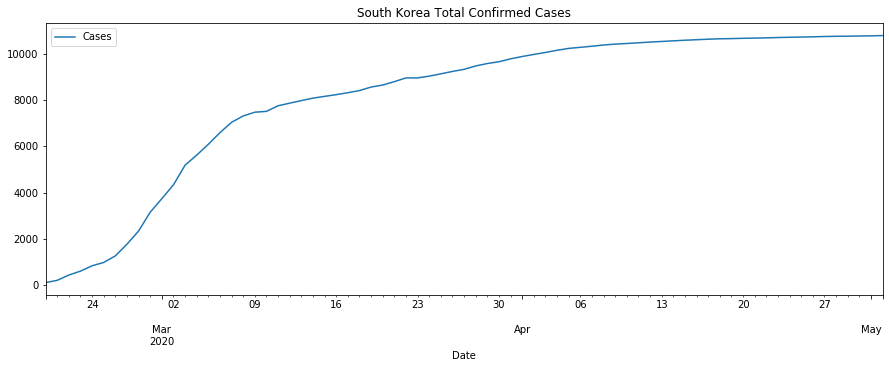

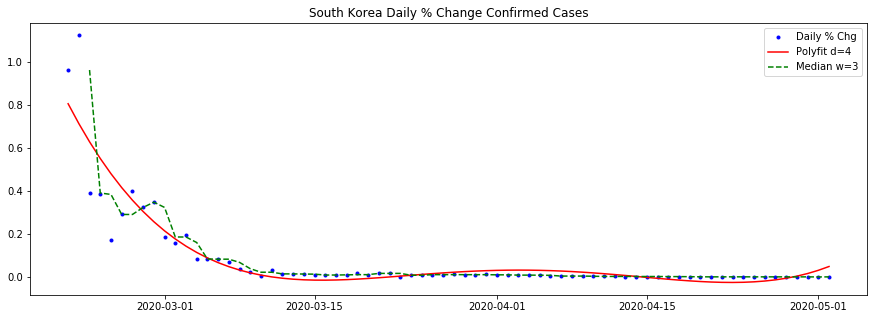

In [72]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Korea, South') & (df_confirmed['Cases'] >= min_cases)]
df_country.plot(y='Cases', title='South Korea Total Confirmed Cases')

ma = y.rolling(window=3).median()
fig, ax = plt.subplots()
plt.title('South Korea Daily % Change Confirmed Cases')
ax.plot(xDate, y, '.b', label='Daily % Chg')
ax.plot(xDate, p(x), '-r', label='Polyfit d=4')
ax.plot(xDate, ma, '--g', label='Median w=3')
leg = ax.legend(loc='upper right', frameon=True);

df_south_korea_testing

#### Plots of Confirmed Cases, Deaths, and Recovered COVID-19 Patients

US and Eurpean like countries

In [73]:
%matplotlib inline

def plot_countries(df, countries, min_cases=50, ls='-', col='Cases'):
    for country in countries:
        df_country = df.loc[(df['Country/Region'] == country) & (df['Cases'] >= min_cases)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)

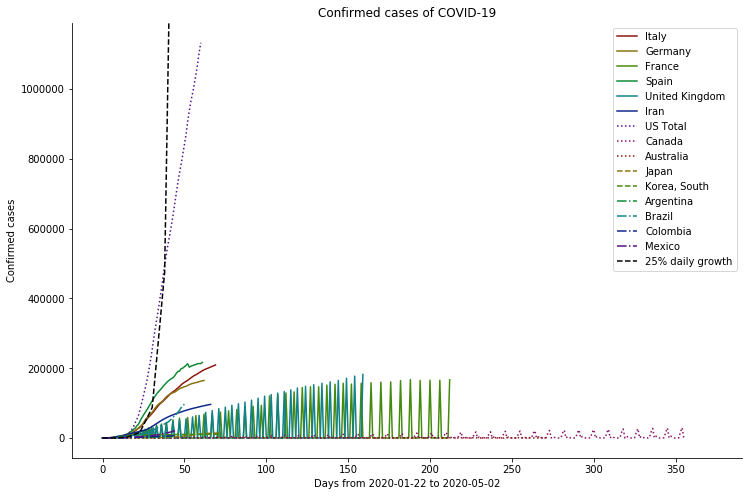

In [77]:
country_groups = [['Italy', 'Germany', 'France', 'Spain', 'United Kingdom', 'Iran'], 
                  ['US Total', 'Canada', 'Australia'], 
                  ['Japan', 'Korea, South'], 
                  ['Argentina', 'Brazil', 'Colombia', 'Mexico']]
line_styles = ['-', ':', '--', '-.']

# sns.set_palette(sns.color_palette("hls", 12))
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

min_cases=100
for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, min_cases=min_cases, ls=ls)

yl = ax.get_ylim() # save so growth plots below can't swamp range
# TODO: Fix xlim going too high - data quality issue / dates out of range?
x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.25) ** x, ls='--', color='k', label='25% daily growth')
ax.set_ylim(yl)

ax.set(title='Confirmed cases of COVID-19',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Confirmed cases')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

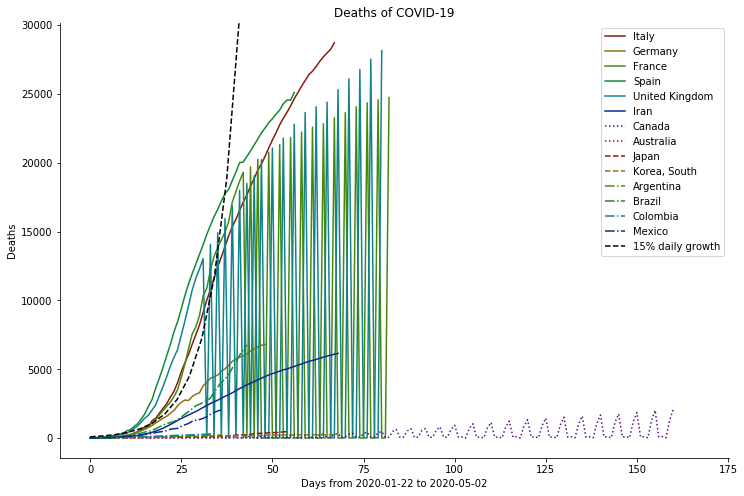

In [78]:
country_groups = [['Italy', 'Germany', 'France', 'Spain', 'United Kingdom', 'Iran'], 
                  ['US Total', 'Canada', 'Australia'], 
                  ['Japan', 'Korea, South'], 
                  ['Argentina', 'Brazil', 'Colombia', 'Mexico']]
line_styles = ['-', ':', '--', '-.']

# sns.set_palette(sns.color_palette("hls", 12))
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

min_cases=10
for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_deaths, countries, min_cases=min_cases, ls=ls)

# TODO: Fix some series going to 0 - missing points reported as 0 instead of cumulative sum?
yl = ax.get_ylim() # save so growth plots below can't swamp range
x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.15) ** x, ls='--', color='k', label='15% daily growth')
ax.set_ylim(yl)

ax.set(title='Deaths of COVID-19',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Deaths')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

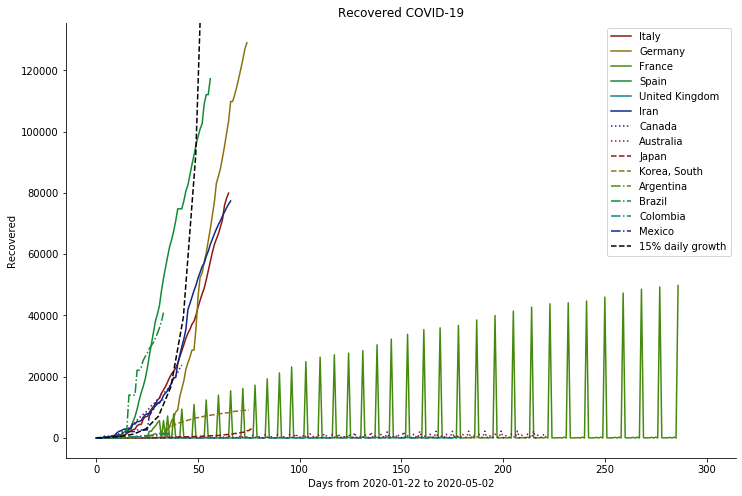

In [80]:
country_groups = [['Italy', 'Germany', 'France', 'Spain', 'United Kingdom', 'Iran'], 
                  ['US Total', 'Canada', 'Australia'], 
                  ['Japan', 'Korea, South'], 
                  ['Argentina', 'Brazil', 'Colombia', 'Mexico']]
line_styles = ['-', ':', '--', '-.']

# sns.set_palette(sns.color_palette("hls", 12))
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

min_cases=10
for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_recovered, countries, min_cases=min_cases, ls=ls)

# TODO: Fix some series going to 0 - missing points reported as 0 instead of cumulative sum?   
yl = ax.get_ylim() # save so growth plot below can't swamp range
x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.15) ** x, ls='--', color='k', label='15% daily growth')
ax.set_ylim(yl)

ax.set(title='Recovered COVID-19',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Recovered')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

#### Population Stats for Normalization

https://www.macrotrends.net/countries/ranking/population 

In [81]:
pop_dict = {'US Total':331002651,
    'Japan':126476461,
    'Germany':83783942,
    'United Kingdom':67886011,
    'France':6273511,
    'Italy':60461826,
    'Korea, South':51269185,
    'Spain':46754778,
    'Argentina':45195774,
    'Canada':37742154,
    'Australia':25499884,
    'Taiwan':23816775,
    'Iran':8992949,
    'Brazil':209469333,
    'Colombia':49648685,
    'Mexico':126190788
}

In [82]:
pop_dict['US Total']

331002651

#### Plot by normaling cases by population per 1M people

In [83]:
%matplotlib inline

def plot_countries_norm(df, countries, min_cases=50, ls='-', col='Cases'):
    for country in countries:
        df_country = df.loc[(df['Country/Region'] == country) & (df['Cases'] >= min_cases)].copy(deep=True)
        df_country['Cases']=df_country['Cases']*1000000/pop_dict[country]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)
#         df_country.plot(y='Cases', label=country, ls=ls)

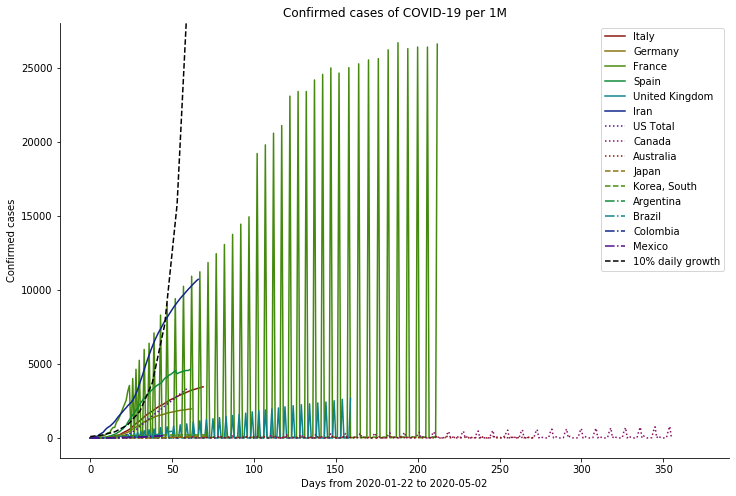

In [84]:
country_groups = [['Italy', 'Germany', 'France', 'Spain', 'United Kingdom', 'Iran'], 
                  ['US Total', 'Canada', 'Australia'], 
                  ['Japan', 'Korea, South'], 
                  ['Argentina', 'Brazil', 'Colombia', 'Mexico']]
line_styles = ['-', ':', '--', '-.']

# sns.set_palette(sns.color_palette("hls", 12))
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

min_cases=100
for countries, ls in zip(country_groups, line_styles):
    plot_countries_norm(df_confirmed, countries, min_cases=min_cases, ls=ls)

yl = ax.get_ylim()
x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.10) ** x, ls='--', color='k', label='10% daily growth')
ax.set_ylim(yl)

ax.set(title='Confirmed cases of COVID-19 per 1M',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Confirmed cases')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

#### US Confirmed COVID-19 Cases and SPY Index

[*********************100%***********************]  1 of 1 completed


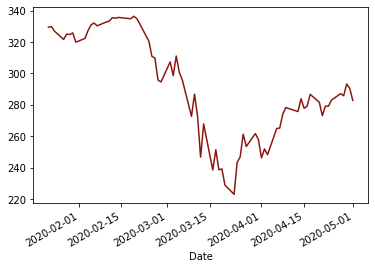

In [86]:
%matplotlib inline
# Import the yfinance. 
import yfinance as yf

# Get the data for the stock AAPL
data = yf.download('SPY', min_date_string, max_date_string)

# Import the plotting library
import matplotlib.pyplot as plt

# Plot the close price of the AAPL
data['Adj Close'].plot()
plt.show()

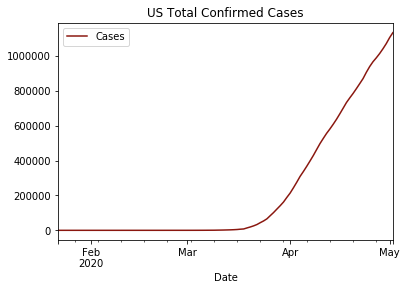

In [87]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'US Total') ]
df_country.plot(y='Cases', title='US Total Confirmed Cases');

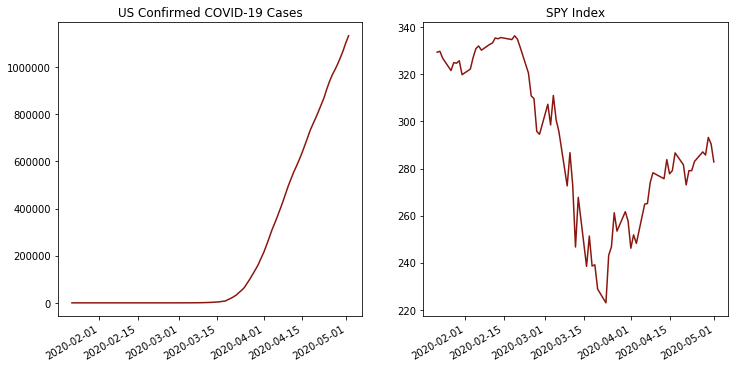

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.autofmt_xdate()
ax[0].title.set_text('US Confirmed COVID-19 Cases')
ax[0].plot(df_country.index, df_country['Cases'], label='US Cases')
ax[0].xaxis_date()
ax[1].plot(data.index, data['Adj Close'], label='SPY')
ax[1].title.set_text('SPY Index')
ax[1].xaxis_date()
plt.show();

In [89]:
df_china_hubei = df_confirmed.loc[(df_confirmed['Country/Region'] == 'China') & (df_confirmed['Province/State'] == 'Hubei') ]


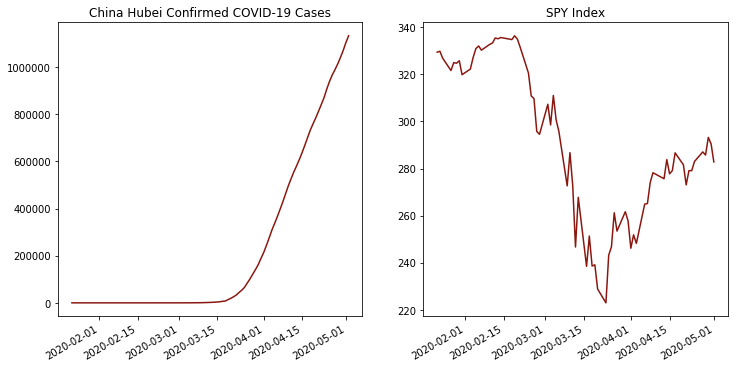

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.autofmt_xdate()
ax[0].title.set_text('China Hubei Confirmed COVID-19 Cases')
ax[0].plot(df_china_hubei.index, df_country['Cases'], label='US Cases')
ax[0].xaxis_date()
ax[1].plot(data.index, data['Adj Close'], label='SPY')
ax[1].title.set_text('SPY Index')
ax[1].xaxis_date()
plt.show();

The stock market collapsed way before the COVID-19 confirmed cases. So we can't use COVID-19 to predict the market, but we may be able to use the market to predict COVID-19.

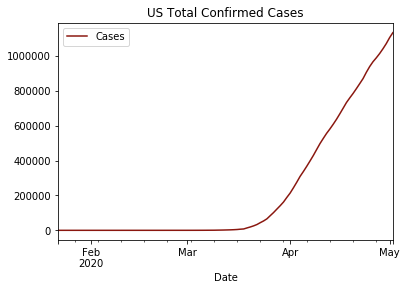

In [91]:
df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'US Total') ]
df_country.plot(y='Cases', title='US Total Confirmed Cases');

#### South Korea Confirmed and Recovered COVID-19 Cases

Korea has used aggressive testing

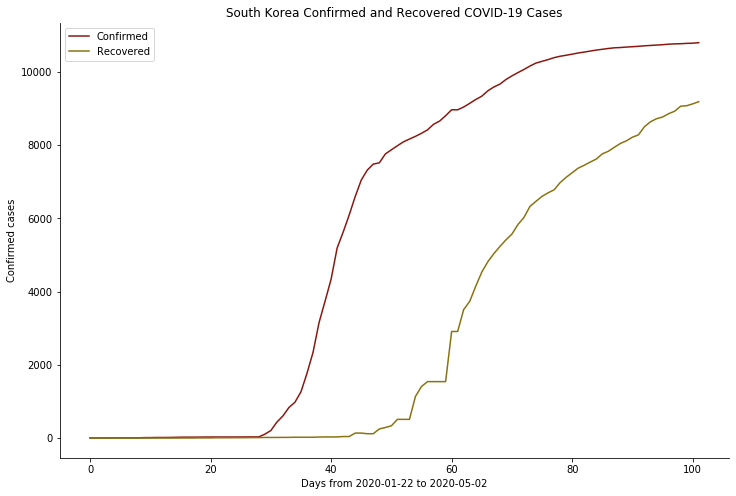

In [92]:
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Korea, South') ]
df_country.reset_index()['Cases'].plot(label='Confirmed')
df_country = df_recovered.loc[(df_recovered['Country/Region'] == 'Korea, South') ]
df_country.reset_index()['Cases'].plot(label='Recovered')

ax.set(title='South Korea Confirmed and Recovered COVID-19 Cases',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Confirmed cases')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

#### Italy Confirmed and Recovered COVID-19 Cases

Italy appears behind the curve

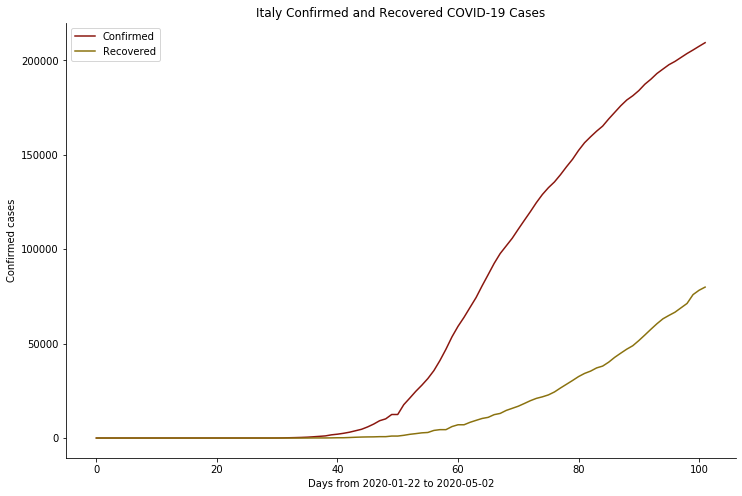

In [93]:
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
fig, ax = plt.subplots(figsize=(12, 8))

df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Italy') ]
df_country.reset_index()['Cases'].plot(label='Confirmed')
df_country = df_recovered.loc[(df_recovered['Country/Region'] == 'Italy') ]
df_country.reset_index()['Cases'].plot(label='Recovered')

ax.set(title='Italy Confirmed and Recovered COVID-19 Cases',
       xlabel='Days from {} to {}'.format(min_date_string, max_date_string),
       ylabel='Confirmed cases')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc=0)

sns.despine();

#### Curve Fitting

[-6.77109849e-01  2.14555388e+02 -2.69687734e+03]
[1.5165695 1.        0.5      ]


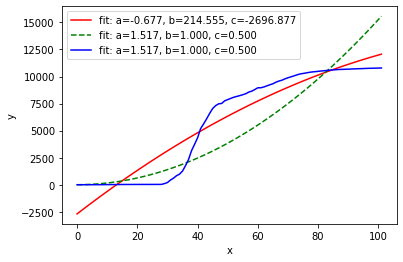

In [94]:
from scipy.optimize import curve_fit
import math

def func(x, a, b, c):
    return a*x**2 + b*x + c

df_country = df_confirmed.loc[(df_confirmed['Country/Region'] == 'Korea, South') ].copy(deep=True)
df_country = df_country.reset_index()
ydata = df_country['Cases']
xdata = df_country.index

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
print(popt)

plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.plot(xdata, ydata, 'b-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [95]:
df_state_raw = pd.read_csv('https://covidtracking.com/api/v1/us/daily.csv', parse_dates=['date',])
df_state=df_state_raw.set_index(['date'])
df_state

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-05-02,56,1125719,5690628.0,1578.0,51554.0,123860.0,9403.0,4386.0,4845.0,375.0,...,123860.0,6817925,6816347,6816347,NaN,1651.0,2112.0,234499.0,30038.0,264537.0
2020-05-01,56,1095681,5456129.0,1639.0,52370.0,121748.0,9205.0,4300.0,4707.0,376.0,...,121748.0,6553449,6551810,6551810,NaN,1743.0,9793.0,271571.0,33547.0,305118.0
2020-04-30,56,1062134,5184558.0,2775.0,53793.0,111955.0,9486.0,4192.0,4712.0,373.0,...,111955.0,6249467,6246692,6246692,NaN,2091.0,2265.0,191545.0,28977.0,220522.0
2020-04-29,56,1033157,4993013.0,4832.0,54930.0,109690.0,9612.0,4093.0,4796.0,365.0,...,109690.0,6031002,6026170,6026170,NaN,2700.0,3382.0,202877.0,27565.0,230442.0
2020-04-28,56,1005592,4790136.0,4206.0,54940.0,106308.0,9491.0,3798.0,4760.0,195.0,...,106308.0,5799934,5795728,5795728,NaN,2198.0,2059.0,177775.0,24458.0,202233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0
2020-01-25,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0
2020-01-24,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,0.0,0.0,0.0,0.0,0.0


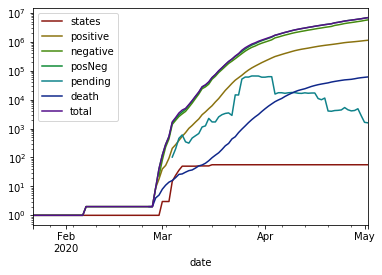

In [97]:
df_state[['states','positive','negative','posNeg','pending','death','total']].plot(logy=True)

In [98]:
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2)

In [99]:
measurements = [[1,0], [0,0], [0,1]]
kf.em(measurements).smooth([[2,0], [2,1], [2,2]])[0]
# array([[ 0.85819709],
#        [ 1.77811829],
#        [ 2.19537816]])

array([[0.85819709],
       [1.77811829],
       [2.19537816]])